# Projeto Aprendizagem Automática Avançada

# Trabalho laboratorial Nº 2

### Alunos: 
* A45102 Miguel Távora
* A45140 Duarte Domingues


<hr style="border:2px solid black"> </hr>

### Imports

In [3]:
import pickle
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.datasets as DT
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve
import sklearn.metrics as skm
from sklearn.preprocessing import StandardScaler


### Carregar os dados

In [195]:
file_pickle="xorData.p"

In [5]:
dic = None
with open(file_pickle, 'rb') as f:
    dic = pickle.load(f)

In [6]:
X = dic['data']
y = dic['target']*2-1

O intervalo dos valores de y foi convertido de [0,1] para [-1,1]. Como se utilizou uma tangente hiperbólica para as funções de ativação da rede, cujo o intervalo é [-1,1], é preferível utilizar classes [-1,1], de forma a facilitar o treino da rede.

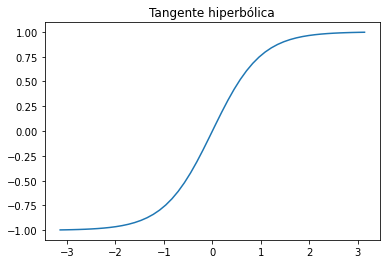

In [206]:
in_array = np.linspace(-np.pi, np.pi, 50) 
out_array = np.tanh(in_array) 
plt.plot(in_array, out_array) 
plt.title("Tangente hiperbólica") 

plt.show()

In [7]:
X.shape

(2, 1000)

In [8]:
y.shape

(1000,)

<hr style="border:2px solid black"> </hr>

### Função auxiliar de visualização da matriz de confusão

In [9]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig=plt.figure(figsize=(6.5,6.5))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

### Shuffle dos dados

Inicialmente é necessário realizar shuffle dos dados, pois os dados inicialmente encontram-se todos organizados.

In [10]:
idx = np.random.permutation(len(y))
y=y[idx]
X=X[:,idx]

### Distribuição dos dados

(-0.32084122049357183,
 2.3556820870397392,
 -0.4673923146919918,
 2.2791060953997255)

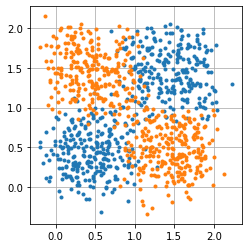

In [11]:
plt.plot(X[0,y==-1],X[1,y==-1],'.')
plt.plot(X[0,y==1],X[1,y==1],'.')

plt.grid(True)
plt.axis('scaled')

A partir do seguinte gráfico, pode-se observar como os dados estão dispersos por classes.
Através da observação do gráfico, é de notar que os dados têm os centroides em:

* (0.5,0.5)
* (0.5,1.5)
* (1.5,0.5)
* (1.5,1.5)

<hr style="border:2px solid black"> </hr>

# Implementação da rede  (MLP) para classificação binária (problema XOR)

Neste trabalho imlementou-se uma rede MLP de três camadas, para o processo de classificação de dados bi-dimensionais, com o intuito de resolver o problema XOR.

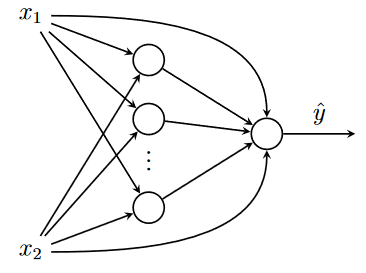

A rede é composta uma camada de entrada (X1, X2) , um número arbitrário de unidades escondidas (inicialmente a rede vai ser testada com apenas uma unidade escondida ) e um perceptrão na camada de saída.

A camada de entrada (X1 e X2) têm uma conexão direta para a camada de saída.

O processo de treino da rede neuronal tem 4 partes:

## Forward Propagation 

Cada instância de treino, x[n] é passada pela network de forma a produzir um output $\hat{y}[n]$.

* u é o produto matricial  entre os pesos e o vector de input mais as biases.
* v é a tangente hiperbólica de u.
* z é o produto matricial de u com v mais a bias.
* É necessário atribuir os pesos à camada de entrada que se vai ligar á camada de saída, zx2 vai equivaler ao produto matricial do peso de X1 com X1, e zx3 o produto matricial do peso de X2 com X2.
* yh é o output predicto dada pela função de activação tangente hiperbólica no neutrão de output.


In [12]:
def forward_pass(X,Wi,Wo,b,bo,Wi2,Wi3):
    u = np.dot(Wi.T, X) + b
    v = np.tanh(u)
    
    zx2 = np.dot(Wi2, np.reshape(X[0],(1,len(X[0]))))
    zx3 = np.dot(Wi3, np.reshape(X[1],(1,len(X[1]))))
    z = np.dot(Wo.T, v)+bo +zx2+ zx3

    yh = np.tanh(z) #network prediction
    
    return u,v,z,yh

<hr style="border:2px solid black"> </hr>

## Calculo da função de erro

A função de erro é uma estimativa do desempenho da network. O erro deve diminuir ao longo das EPOCHS até chegar a um valor baixo estável.

O erro é calculado a partir da função Mean Squared Error (MSE).

$e[n] = \sum \limits _{i} (y_{i}-\hat{y}_{i})^2 $

## Backward propagation 
Nesta fase o erro encontrado no modelo é "back propagated" para ajustar os pesos e biases que diminuem o valor da função de erro.
Começa-se a back propegation com yh e tenta-se encontrar a taxa de mudança de erro em relacao ao Wo.
O algoritmo de back propagation funciona da layer de output para a layer de input, propagando os gradientes de erro.

* Primeiro é calculado o gradiente para os weights de output (Wo).

$ \frac{\partial E}{\partial w_{o}} = -\frac{2}{N} \sum \limits _{n}e[n](1-\hat{y}[n]^2)v[n]$

* Em segundo é calculado as biases de input (b).

$ \frac{\partial E}{\partial b} = -\frac{2}{N} \sum \limits _{n}e[n](1-\hat{y}[n]^2)w_{o}(1-v[n]^2)$

* Em terceiro é calculado on weights de input (Wi).

$ \frac{\partial E}{\partial W_{i}} = -\frac{2}{N} \sum \limits _{n}e[n](1-\hat{y}[n]^2)x[n](w_{o}(1-v[n]^2))^T $


* Nesta fase é tambem necessário ajustar os pesos, realizando um dot product entre a saida de dz e as entradas X1 e X2.


In [13]:
def back_pass(y,yh,X,v,Wo,E,alpha,dzWi,dzb,dzWo,dzbo):
    
    dz = -2 * E * (1-yh**2)
    dbo = np.sum(dz)
    # gradient output weights
    dWo = np.dot(v, dz.T)
    du = (1-v**2) * np.dot(Wo, dz)
    #gradient input biases
    db = np.sum(du, axis=1) #derivada de b
    #gradient input weights
    dWi = np.dot(X, du.T)
    dWi2 = np.dot(X[0].reshape(1,len(X[0])),dz.T)
    dWi3 = np.dot(X[1].reshape(1,len(X[1])),dz.T)
    

    return dWi,dbo,du,db,dWo,dWi2,dWi3
    

<hr style="border:2px solid black"> </hr>

## Adaptação dos pesos

Os pesos (W) são adaptados por fim utilizando a fórmula do gradient descent:

W = Wi - lr * $ \frac{\partial E}{\partial W_{i}}$ (dWi), sendo lr o valor da learning rate.

Assim os pesos são updatados por iterações (EPOCHS), em que cada 
EPOCH é composta por uma forward e uma backward propagation, são feitas EPOCHS enquanto a loss está a decrescer até encontrarmos um ponto em que loss é minima e a precisão é adequada.

O modelo decide o quanto tem que mexer os pesos através do parâmetro Learning Rate, denotado por Alpha.

<hr style="border:2px solid black"> </hr>

## Implementação da rede neuronal (1.a)

In [14]:
class NeuralNet():
    
    def __init__(self,X,y,H,alpha,eta,n_iter):
        self.X=X
        self.y=y
        self.H = H
        self.Wi=np.random.randn(2, H) * .1
        self.b = np.zeros((H, 1))
        self.Wo = np.random.randn(H, 1) * .1
        self.bo=0
        self.dzWi = np.zeros(self.Wi.shape)  #array para adaptar weights de input
        self.dzb= np.zeros(self.b.shape) #array para adaptar bias
        self.dzWo= np.zeros(self.Wo.shape) #array para adaptar weights de output
        self.dzbo = 0 #valor para adaptar a bias
        self.n_iter=n_iter #Numero de EPOCHS
        self.Error = np.zeros(n_iter) #array do erro
        # adaptar os pesos
        self.alpha = alpha
        self.eta = eta
        self.Wi2 = rd.randn(1,1) * .1
        self.Wi3 = rd.randn(1,1) * .1
        self.dzWi2 = np.zeros(self.Wi2.shape)
        self.dzWi3 = np.zeros(self.Wi3.shape)
    
    def forward_pass(self,X,Wi,Wo,b,bo,Wi2,Wi3):
        u = np.dot(Wi.T, X) + b
        v = np.tanh(u)
    
        zx2 = np.dot(Wi2, np.reshape(X[0],(1,len(X[0]))))
        zx3 = np.dot(Wi3, np.reshape(X[1],(1,len(X[1]))))
        z = np.dot(Wo.T, v)+bo +zx2+ zx3

        yh = np.tanh(z) #network prediction
    
        return u,v,z,yh
    
    def back_pass(self,y,yh,X,v,Wo,E,alpha,dzWi,dzb,dzWo,dzbo):
    
        dz = -2 * E * (1-yh**2)
        dbo = np.sum(dz)
        # gradient output weights
        dWo = np.dot(v, dz.T)
        du = (1-v**2) * np.dot(Wo, dz)
        #gradient input biases
        db = np.sum(du, axis=1) #derivada de b
        #gradient input weights
        dWi = np.dot(X, du.T)
        dWi2 = np.dot(X[0].reshape(1,len(X[0])),dz.T)
        dWi3 = np.dot(X[1].reshape(1,len(X[1])),dz.T)
    

        return dWi,dbo,du,db,dWo,dWi2,dWi3

    def train(self):
        yh_return=None
        for n in range(self.n_iter):
            
            #forward pass
            u,v,z,yh= self.forward_pass(self.X,self.Wi,self.Wo,self.b,self.bo,self.Wi2,self.Wi3)
            
            #Calculate Error 
            E = self.y - yh
            self.Error[n] = np.mean(E**2)
            
            #back propagation
            dWi,dbo,du,db,dWo,dWi2,dWi3=self.back_pass(self.y,yh,self.X,v,self.Wo,E,self.alpha,self.dzWi,self.dzb,self.dzWo,self.dzbo)
            
            #adapt
            self.dzWi=self.alpha*self.dzWi+dWi
            
            self.dzWi2=self.alpha*self.dzWi2+dWi2
            self.dzWi3=self.alpha*self.dzWi3+dWi3
    
            self.dzb=self.alpha*self.dzb+db[:,np.newaxis]
            self.dzWo=self.alpha*self.dzWo+dWo    
            self.dzbo=self.alpha*self.dzbo+dbo
    
            self.Wi=self.Wi-self.eta*self.dzWi
            self.Wi2=self.Wi2-self.eta*self.dzWi2
            self.Wi3=self.Wi3-self.eta*self.dzWi3
            self.b=self.b-self.eta*self.dzb
            self.Wo=self.Wo-self.eta*self.dzWo
            self.bo=self.bo-self.eta*self.dzbo
            
            yh_return = yh
        return yh_return
            

#### Função do Gráfico da dispersão dos valores obtidos pela função de saída da rede


In [24]:
def plot_yh(yh):
    plt.figure(figsize=(10,5))
    plt.plot(yh.squeeze(),'.')
    

#### Função de visualização dos erros obtidos da função de saída da rede separados por classe

In [25]:
def plot_errors(yh):
    
    plt.figure(figsize=(6,6))
    ye=(yh.squeeze()>=0)*2-1  #converter o intervalo de yh de [0,1] para [-1,1]
    plt.plot(X[0,y==-1],X[1,y==-1],'.b')
    plt.plot(X[0,y==1],X[1,y==1],'.r')
    plt.plot(X[0,y!=ye],X[1,y!=ye],'ok',alpha=.7)
    print('Nº de erros:',np.sum(y!=ye))
    score_ = 1-(np.sum(y!=ye)/len(y))
    print('Score:',score_)

    

In [26]:
def get_score(yh):
    
    ye=(yh.squeeze()>=0)*2-1  #converter o intervalo de yh de [0,1] para [-1,1]
    score_ = 1-(np.sum(y!=ye)/len(y))
    return score_

#### Função para obter o gráfico da função de saída da rede

In [42]:
def plot_3d(yh,Wi,b,Wo,bo,Wi2,Wi3):
    gX,gY=np.meshgrid(np.linspace(0,2,50),np.linspace(0,2,50))
    X2=np.vstack((gX.ravel(),gY.ravel()))
    u=np.dot(Wi.T,X2)+ b
    v=np.tanh(u)
    add1=np.dot(Wi2.T,np.reshape(X2[0],(1,len(X2[0]))))
    add2=np.dot(Wi3.T,np.reshape(X2[1],(1,len(X2[1]))))
    z=np.dot(Wo.T,v)
    yh=np.tanh(z+add1+add2+bo)
    Yh=np.reshape(yh,(50,50))

    from mpl_toolkits import mplot3d
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    #ax.contour3D(gX,gY,Yh,50,cmap='binary')
    ax.plot_wireframe(gX,gY,Yh)

<hr style="border:2px solid black"> </hr>

## Treino da rede Neuronal e averiguação dos melhores parâmetros (1.b)

Inicialmente começou-se por treinar a rede neuronal com apenas uma unidade escondida.

Naturalmente uma rede com apenas um perceptrão na hidden layer não iria conseguir resolver o problema XOR, pois com apenas um perceptrão a rede só é capaz de aprender padrões linearmente separavéis. Porém o XOR não é um problema linearlmente separavél.

Para combater o problema realizou-se uma ligação direta da camada de entrada (X1 e X2) para a camada de saída. Desta maneira, aumenta a flexibilidade da rede, tendo disponivél um maior número de interseções para resolver o problema XOR, tornado esta adaptação menos linear.


### Treino da rede com Numero de Unidades Escondidas = 1

A partir de diferentes testes, da observação da variação do erro e dos resultados obtidos definiu-se os seguintes parâmetros como os melhores:

* alpha = 0.7
* eta = 1e-4
* num_iteracoes = 5000

Foi realizado o seguinte código para testar diferentes combinações para os valores de alpha e eta que produzem o menor número de erros.

In [199]:
alphas=(0.1,0.3,0.5,0.7,0.9)
etas=(1e-3,1e-4,1e-5)

combs=[]

for i in range (len(alphas)):
    for j in range (len(etas)):
        combs.append((alphas[i],etas[j]))

best_score=[0,0,0]

for i in range (len(combs)):
    net_i = NeuralNet(X,y,1,combs[i][0],combs[i][1],2000)
    yh = net_i.train()
    score_net_i=get_score(yh)
    if(score_net_i>best_score[0]):
        best_score[0] = score_net_i
        best_score[1] =combs[i][0]
        best_score[2] = combs[i][1]

print(best_score)


[0.847, 0.7, 1e-05]


In [37]:
neural_net_1 = NeuralNet(X,y,1,0.7,1e-4,5000)
yh = neural_net_1.train()

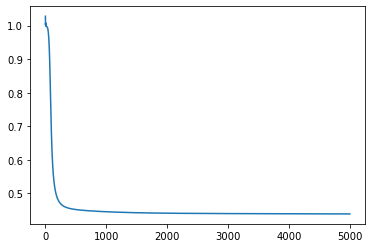

In [38]:
plt.plot(neural_net_1.Error)

Como se pode observar a partir do seguinte gráfico, a partir da EPOCH 1000, o erro começa a estabilizar e vai descendo gradualmente até chegar a um valor bastante estavél perto das 3000 EPOCHS. 

O erro mesmo assim ainda está muito elevado, sendo necessário adicionar mais unidades esconidadas de forma a ter resultados mais convincentes.

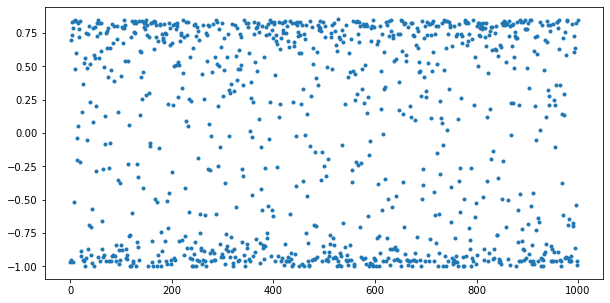

In [39]:
plot_yh(yh)

Como se pode observar pelo gráficos os valores de saida de yh, encontram-se dispersos em polos opostos entre -1 e próximo de 1, devido a ter sido utilizada a tangete hiperbólica para as funções da ativação da rede.

Porém os valores não chegam a 1 porque não há perceptrões suficientes para o valor de saída yh ser 1.

Nº de erros: 148
Score: 0.852


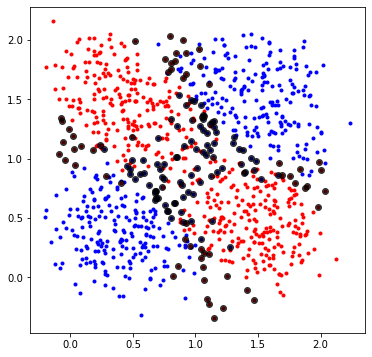

In [40]:
score_list.append(plot_errors(yh))

O score obtido foi 0.852.

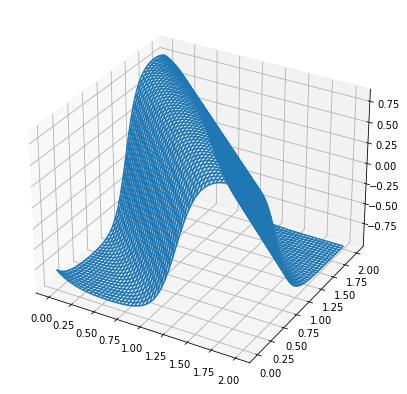

In [43]:
plot_3d(yh,neural_net_1.Wi,neural_net_1.b,neural_net_1.Wo,neural_net_1.bo,neural_net_1.Wi2,neural_net_1.Wi3)

A partir da visualização do gráfico é possivel observar a adaptação do modelo ao problema. O modelo contorceu-se de modo a que seja criadas 2 regiões, uma inferior para acomodar os quadrantes da classe -1 e outra região superior para os quadrantes da classe 1. 

A união das duas regiões não têm  uma separação acentuada, sendo ainda muito linear.

<hr style="border:2px solid black"> </hr>

### Treino da rede com o Número de Unidades Escondidas = 10 (1.c)

A rede neuronal foi também treinada com 10 unidades escondidas, de seguida estão apresentados os seguintes resultados obtidos.

In [44]:
neural_net_10 = NeuralNet(X,y,10,0.7,1e-4,5000)
yh = neural_net_10.train()

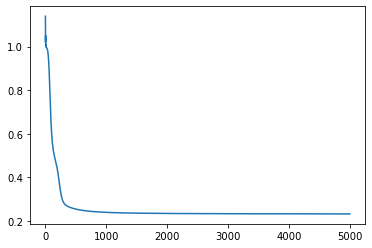

In [45]:
plt.plot(neural_net_10.Error)

Como se pode observar pelo gráfico da evolução do erro ao longo do tempo o erro é muito inferior do que o erro obtido com apenas 1 unidade escondida, tendo então a rede um muito melhor desempenho a elaborar o problema do XOR.

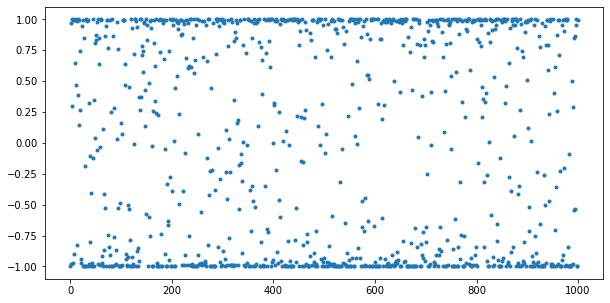

In [46]:
plot_yh(yh)

Como se pode observar no gráfico, com um número maior de unidades escondidas a rede consegue polarizar melhor os valores obtidos para a função de saída yh, tendo os valores mariotarimente em -1 e 1, chegando agora a 1.

Nº de erros: 90
Score: 0.91


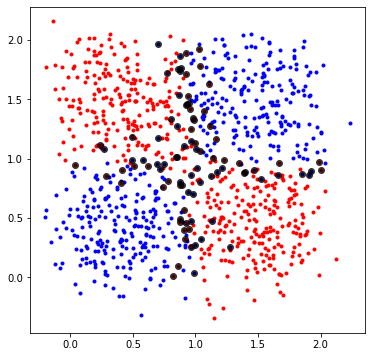

In [47]:
score_list.append(plot_errors(yh))

O número de erros diminui drásticamente quando comparado com o anterior, tendo um score de 0.911

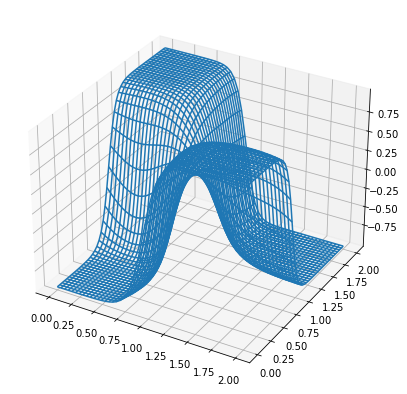

In [49]:
plot_3d(yh,neural_net_10.Wi,neural_net_10.b,neural_net_10.Wo,neural_net_10.bo,neural_net_10.Wi2,neural_net_10.Wi3 )

A partir da visualização do gráfico é possivel observar a adaptação do modelo ao problema. Com 10 unidades escondidas é possível observar de forma mais evidente a sepração entre as regiões dos quadrantes da classe -1 e dos quadrantes da classe 1. 

O modelo já não se encontra tao linear, tendo separações mais acentuadas.


<hr style="border:2px solid black"> </hr>

### Treino da rede com o Número de Unidades Escondidas = 50 (1.d)

In [50]:
neural_net_50 = NeuralNet(X,y,50,0.7,1e-4,5000)
yh = neural_net_50.train()

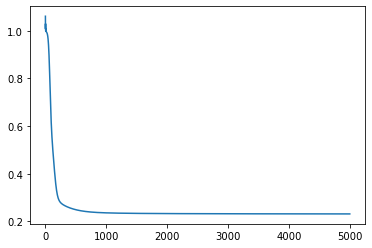

In [51]:
plt.plot(neural_net_50.Error)

O gráfico da evolução do erro ao longo do tempo não varia muito em comparação com o da com unidades escondidas igual a 10.

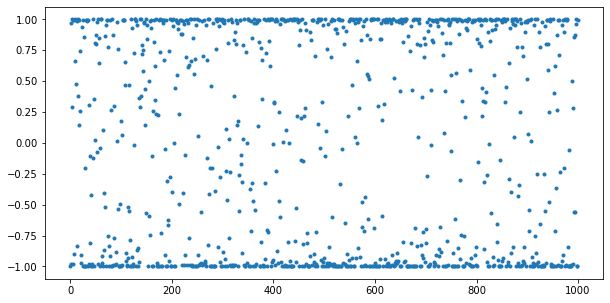

In [52]:
plot_yh(yh)

É possível observar plenamente a polarização dos valores de saída de yh entre [-1,1]

Nº de erros: 91
Score: 0.909


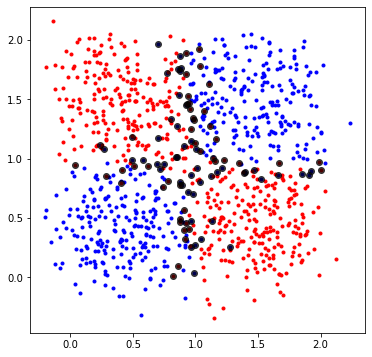

In [53]:
score_list.append(plot_errors(yh))

O score manteve-se básicamente semelhante ao obtido para 10 unidades escondidas.

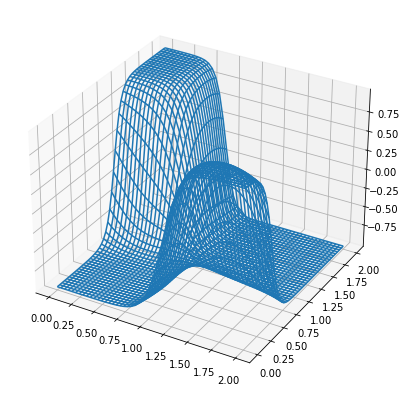

In [54]:
plot_3d(yh,neural_net_50.Wi,neural_net_50.b,neural_net_50.Wo,neural_net_50.bo, neural_net_10.Wi2,neural_net_10.Wi3)

Não há diferenças muito evidentes entre este gráfico e o gráfico obtido para 10 unidades escondidas, sendo um gráfico com ambas as regiões da classe -1 e 1 separadas de forma mais evidente.

### Observações

* Converter a gama de valores das classes de [0,1] para [-1,1] permitiu obter um melhor desempenho da rede devido a ser utilizada a tangente hiperbólica nas funções de saída.

* Não houve diferença consideravél entre utilizar 10 unidades escondidas e 50, não sendo benéfico aumentar em demasia o número de unidades de escondidas. Uma alternativa para melhorar o desempenho do modelo seria aumentar o número de camadas escondidas.


<hr style="border:2px solid black"> </hr>

#### Exemplificação de predict de dados de teste, a partir da rede Neuronal pre-treinada

Os seguintes numpys arrays irão ser utilizados como teste para exemplificar o predict da rede neuronal treinada.

In [241]:
test_1 =np.array([[0.5],[0.5]])
test_2 =np.array([[0.5],[1.5]])
test_3 =np.array([[1.5],[0.5]])
test_4 =np.array([[1.5],[1.5]])

Como nos dados fornecidos os centroides das diferente classes encontram-se em:

* (0.5,0.5)
* (0.5,1.5)
* (1.5,0.5)
* (1.5,1.5)

Está-se a realizar predict a partir de valores do teste 0.5 décimas acima do normal.

In [240]:
def predict(X,Wi,Wo,b,bo):
    u,v,z,yh = forward_pass(X,Wi,Wo,b,bo,Wi2,Wi3)
    y_predict = np.squeeze(yh)
    if yh>=0.5:
        print("For input", [i[0] for i in X], "output is 1")
    else:
        print("For input", [i[0] for i in X], "output is 0")

    

In [242]:
predict(test_1,neural_net_50.Wi,neural_net_50.Wo,neural_net_50.b,neural_net_50.bo)
predict(test_2,neural_net_50.Wi,neural_net_50.Wo,neural_net_50.b,neural_net_50.bo)
predict(test_3,neural_net_50.Wi,neural_net_50.Wo,neural_net_50.b,neural_net_50.bo)
predict(test_4,neural_net_50.Wi,neural_net_50.Wo,neural_net_50.b,neural_net_50.bo)


For input [0.5, 0.5] output is 0
For input [0.5, 1.5] output is 1
For input [1.5, 0.5] output is 1
For input [1.5, 1.5] output is 0


<hr style="border:2px solid black"> </hr>

# PARTE 2


Nesta etapa vai-se treinar e testar redes MLP com a base de dados CIFAR-10.

### Carregar a base de dados CIFAR-10

In [179]:
# the data is already shuffled
cifar10=keras.datasets.cifar10
(Xtrain,ytrain),(Xtest,ytest)=cifar10.load_data()

In [180]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [181]:
Xtrain.shape

(50000, 32, 32, 3)

In [182]:
ytrain.shape

(50000, 1)

### Reshape dos dados

In [183]:
Xtrain=Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]**2*Xtrain.shape[3]))*1. #reshape e converter para float
Xtest=Xtest.reshape((Xtest.shape[0],Xtest.shape[1]**2*Xtest.shape[3]))*1. #reshape e converter para float
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)


(50000, 3072)
(10000, 3072)
(50000, 1)
(10000, 1)


### Shuffle dos dados

In [184]:
idx=rd.permutation(Xtrain.shape[0])
Xtrain=Xtrain[idx]*1.#/255-.5#Normalization
ytrain=ytrain[idx]

idx=rd.permutation(Xtest.shape[0])
ytest=ytest[idx]
Xtest=Xtest[idx]*1.#/255-.5#Normalization


### Categorizar os dados

A partir do método to_categorical() do keras é possível realizar one-hot-enconding, que é uma representação de variáveis categóricas como vectores binários.

In [185]:
ytrain_c=keras.utils.to_categorical(ytrain)
ytest_c =keras.utils.to_categorical(ytest)

<hr style="border:2px solid black"> </hr>

## Treinar rede MLP com 10 camadas escondidas, com 100 unidades por camada (2.a)

Foi treinada a rede MLP com os seguintes parâmetros:

* Função de activação das camadas escondidas - ReLU
* Função de activação para a camada de saída - softmax
* Número de unidades da camada de saída - 10
* Optimização - Nadam

In [186]:
#Criar Modelo Sequencial
mlp=keras.Sequential()

mlp.add(keras.layers.Dense(100, input_shape=(3072,), activation="relu"))

mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))
mlp.add(keras.layers.Dense(100, activation="relu"))

mlp.add(keras.layers.Dense(10, activation="softmax"))

In [187]:
mlp.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 100)               307300    
                                                                 
 dense_130 (Dense)           (None, 100)               10100     
                                                                 
 dense_131 (Dense)           (None, 100)               10100     
                                                                 
 dense_132 (Dense)           (None, 100)               10100     
                                                                 
 dense_133 (Dense)           (None, 100)               10100     
                                                                 
 dense_134 (Dense)           (None, 100)               10100     
                                                                 
 dense_135 (Dense)           (None, 100)             

In [188]:
mlp.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

No processo de treino vai ser utilizado um conjunto de validação para conseguir avaliar o quão bom o modelo é a generalizar para novos dados.

In [189]:
train = mlp.fit(Xtrain, ytrain_c, epochs=20, batch_size=1024, validation_data=(Xtest, ytest_c))

Epoch 1/20
49/49 [==============================] - 4s 34ms/step - loss: 3.3320 - accuracy: 0.1555 - val_loss: 2.1945 - val_accuracy: 0.1926
Epoch 2/20
49/49 [==============================] - 2s 33ms/step - loss: 2.1235 - accuracy: 0.2194 - val_loss: 2.2117 - val_accuracy: 0.2125
Epoch 3/20
49/49 [==============================] - 1s 30ms/step - loss: 2.0398 - accuracy: 0.2549 - val_loss: 2.0161 - val_accuracy: 0.2668
Epoch 4/20
49/49 [==============================] - 1s 29ms/step - loss: 1.9759 - accuracy: 0.2817 - val_loss: 1.8728 - val_accuracy: 0.3313
Epoch 5/20
49/49 [==============================] - 1s 30ms/step - loss: 1.9316 - accuracy: 0.3006 - val_loss: 1.8238 - val_accuracy: 0.3458
Epoch 6/20
49/49 [==============================] - 1s 29ms/step - loss: 1.8844 - accuracy: 0.3196 - val_loss: 1.8201 - val_accuracy: 0.3410
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 1.8590 - accuracy: 0.3250 - val_loss: 1.8237 - val_accuracy: 0.3358
Epoch 8/20
49

Foi criada a seguinte função para avaliar o desempenho da rede, obtendo o score para o treino e para o teste.

In [190]:
def evaluate(mlp,Xtrain, Xtest,ytest,ytrain):
    #y teste estimado
    y_test_e=mlp.predict(Xtest)
    y_test_e=np.argmax(y_test_e,axis=1)

    #y treino estimado
    y_train_e=mlp.predict(Xtrain)
    y_train_e=np.argmax(y_train_e,axis=1)
    
    ytest=ytest.flatten()
    conf_mat= confusion_matrix(ytest,y_test_e)
    plot_confusion_matrix(conf_mat,classes)
    print('Total numb errors test:',np.sum(ytest!=y_test_e))
    print('Percentage of errors test:', ((np.sum(ytest!=y_test_e))/ytest.shape[0]*100))
    print(skm.classification_report(ytest,y_test_e))
    
    ytrain=ytrain.flatten()
    conf_mat= confusion_matrix(ytrain,y_train_e)
    plot_confusion_matrix(conf_mat,classes)
    print('Total numb errors train:',np.sum(ytrain!=y_train_e))
    print('Percentage of errors train:', ((np.sum(ytrain!=y_train_e))/ytrain.shape[0]*100))
    
    print(skm.classification_report(ytrain,y_train_e))
    

A seguinte função permite visualizar a evolução da rede ao longo das iterações de treino.

In [191]:
def get_train_history(train):
    h=train.history
    h.keys()
    plt.figure(figsize=(10,5))
    plt.plot(h['loss'], label='Loss_train')
    plt.plot(h['val_loss'], label='Loss_val')
    plt.plot(h['accuracy'], label='Accuracy_train')
    plt.plot(h['val_accuracy'], label='Accuracy_val')
    plt.legend()
    plt.grid()
    plt.show()
    

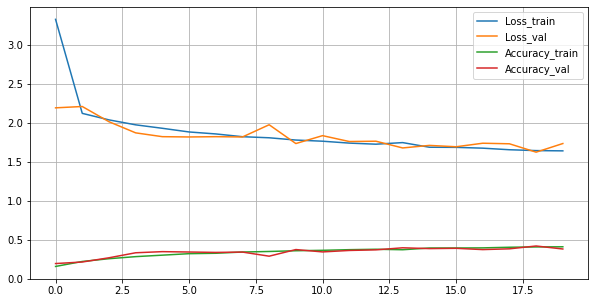

In [192]:
get_train_history(train)

A partir deste gráfico é possível notar que os valores de accuracy do conjunto de treino e de validação são muito semelhantes ao longo das diferentes EPOCHS, isto demonstra que o modelo não está a entrar em sobre-aprendizagem. Os valores da accuracy estão a ascender muito lentamente, por isso ainda poderia ter sido treinado o modelo com um maior número de EPOCHS, visto que a loss também se encontra em descida.

Confusion matrix, without normalization
Total numb errors test: 6202
Percentage of errors test: 62.019999999999996
              precision    recall  f1-score   support

           0       0.54      0.41      0.47      1000
           1       0.49      0.58      0.53      1000
           2       0.31      0.23      0.27      1000
           3       0.22      0.47      0.30      1000
           4       0.38      0.13      0.19      1000
           5       0.32      0.35      0.33      1000
           6       0.36      0.55      0.44      1000
           7       0.65      0.17      0.27      1000
           8       0.46      0.60      0.52      1000
           9       0.53      0.31      0.39      1000

    accuracy                           0.38     10000
   macro avg       0.42      0.38      0.37     10000
weighted avg       0.42      0.38      0.37     10000

Confusion matrix, without normalization
Total numb errors train: 30972
Percentage of errors train: 61.944
              precis

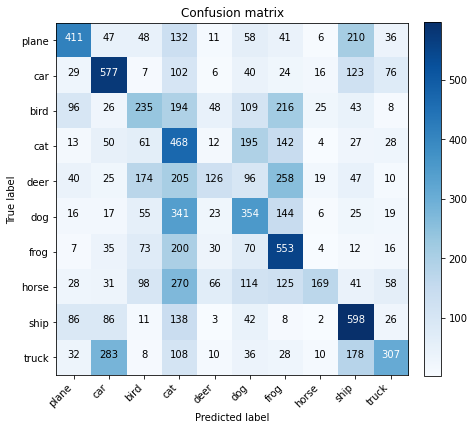

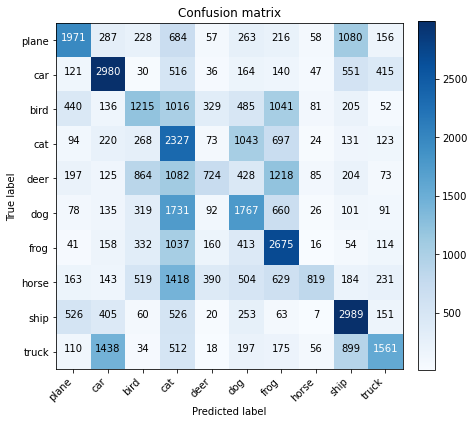

In [193]:
evaluate(mlp,Xtrain, Xtest,ytest,ytrain)

No conjunto de teste foi obtido uma accuracy de 0.38, então o modelo não está a ter um desempenho muito positivo. A única vantagem desta rede é de ser rápida divido à pequena quantidade de unidades por layer.

Pretende-se agora treinar uma rede MLP com parâmetros mais adequados para o problema em questão.

<hr style="border:2px solid black"> </hr>

## Treino de rede MLP com parâmetros óptimos (2.b)

Inicialmente começou-se por determinar um bom número de layers, unidades por layer e averiguar se a utilização de dropout é benéfica. Utilizou-se callback early stopping para parar o treino se não houver nenhuma melhoria na loss por 5 EPOCHS consecutivas e normalização dos dados.

A partir de diferentes testes a rede teve melhor desempenho com:
    
* 1000 unidades layer input
* 5 layers escondidas ( primeira com 1000 unidades e outras com 505)
* layer output com 10 unidades

No treino de forma a ser possivel comparar os resultados com os obtidos anteriormente, utilizou-se os mesmos parâmetros:

* Função de activação das camadas escondidas - ReLU
* Função de activação para a camada de saída - softmax
* Optimização - Nadam

In [82]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [83]:
mlp_1=keras.Sequential()

mlp_1.add(keras.layers.Dense(1000, input_shape=(3072,), activation="relu"))
mlp_1.add(keras.layers.Normalization(mean=128,variance=128))
mlp_1.add(keras.layers.Dense(1000, activation="relu"))
mlp_1.add(keras.layers.Dense(505, activation="relu"))
mlp_1.add(keras.layers.Dense(505, activation="relu"))
mlp_1.add(keras.layers.Dense(505, activation="relu"))
mlp_1.add(keras.layers.Dense(505, activation="relu"))

mlp_1.add(keras.layers.Dense(10, activation="softmax"))
mlp_1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1000)              3073000   
                                                                 
 normalization (Normalizatio  (None, 1000)             0         
 n)                                                              
                                                                 
 dense_22 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_23 (Dense)            (None, 505)               505505    
                                                                 
 dense_24 (Dense)            (None, 505)               255530    
                                                                 
 dense_25 (Dense)            (None, 505)               255530    
                                                      

In [84]:
mlp_1.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

train = mlp_1.fit(Xtrain, ytrain_c, epochs=20, batch_size=1024, callbacks=[callback], validation_data=(Xtest, ytest_c))

Epoch 1/20
49/49 [==============================] - 13s 243ms/step - loss: 6.2417 - accuracy: 0.1473 - val_loss: 2.1761 - val_accuracy: 0.1772
Epoch 2/20
49/49 [==============================] - 10s 205ms/step - loss: 2.1536 - accuracy: 0.2135 - val_loss: 2.0338 - val_accuracy: 0.2633
Epoch 3/20
49/49 [==============================] - 10s 212ms/step - loss: 2.0243 - accuracy: 0.2630 - val_loss: 1.9925 - val_accuracy: 0.2685
Epoch 4/20
49/49 [==============================] - 11s 233ms/step - loss: 1.9736 - accuracy: 0.2839 - val_loss: 1.8466 - val_accuracy: 0.3403
Epoch 5/20
49/49 [==============================] - 10s 211ms/step - loss: 1.9048 - accuracy: 0.3121 - val_loss: 1.8119 - val_accuracy: 0.3464
Epoch 6/20
49/49 [==============================] - 10s 212ms/step - loss: 1.8626 - accuracy: 0.3241 - val_loss: 1.7831 - val_accuracy: 0.3547
Epoch 7/20
49/49 [==============================] - 11s 221ms/step - loss: 1.7875 - accuracy: 0.3514 - val_loss: 1.7805 - val_accuracy: 0.3680

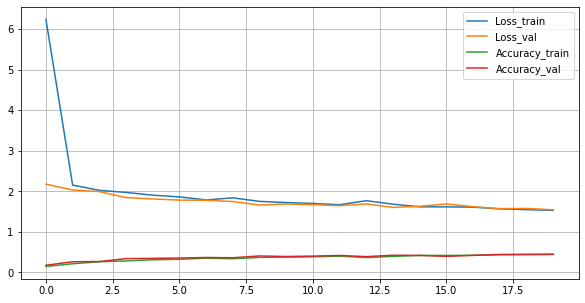

In [96]:
get_train_history(train)

A partir do plot da accuracy é possível vizualisar que o modelo já está muito perto de estar estabilizado nas ultimas EPOCHS, tendo sido escolhido um número de EPOCHS adequado. Também é possivel determinar que o modelo não está em overfitting, visto que a accuracy entre treino e validation encontra-se muito próxima.

Confusion matrix, without normalization
Total numb errors test: 5546
Percentage of errors test: 55.46
              precision    recall  f1-score   support

           0       0.58      0.40      0.47      1000
           1       0.57      0.54      0.55      1000
           2       0.32      0.34      0.33      1000
           3       0.32      0.34      0.33      1000
           4       0.43      0.26      0.32      1000
           5       0.54      0.21      0.30      1000
           6       0.41      0.64      0.50      1000
           7       0.44      0.57      0.50      1000
           8       0.57      0.54      0.55      1000
           9       0.44      0.61      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.44     10000
weighted avg       0.46      0.45      0.44     10000

Confusion matrix, without normalization
Total numb errors train: 26785
Percentage of errors train: 53.56999999999999
              precisio

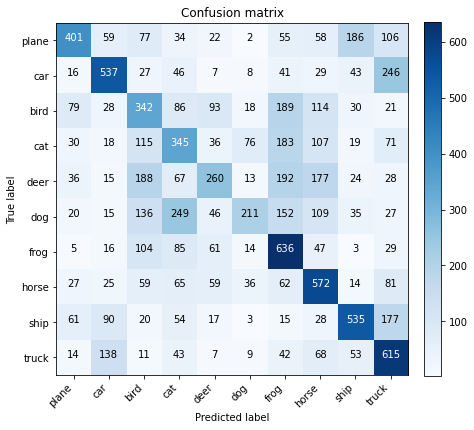

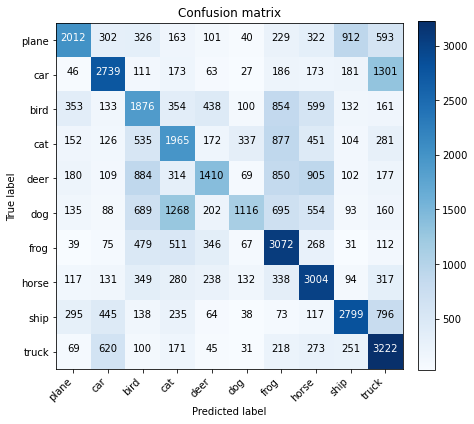

In [97]:
evaluate(mlp_1, Xtrain, Xtest,ytest,ytrain)

No conjunto de teste foi obtido um valor de accuracy de 0.46, que não é muito satisfatório. Portanto irá ser agora testada a adição de camadas de dropout no modelo.

<hr style="border:1px solid black"> </hr>

### Adição de camadas de dropout

Testou-se agora a adição de camadas de dropout. A partir de diferentes testes o melhor valor para a dropout rate foi 0.3. 

A Dropout layer mete de forma aleatória as unidades de input para 0 com uma frequência (dropout rate) em cada step do processo de treino, isto ajuda a prevenir overfitting.


In [99]:
#Criar Modelo Sequencial
mlp2=keras.Sequential()

mlp2.add(keras.layers.Dense(1000, input_shape=(3072,), activation="relu"))
mlp2.add(keras.layers.Normalization(mean=128,variance=128))
mlp2.add(keras.layers.Dropout(.3))
mlp2.add(keras.layers.Dense(1000, activation="relu"))

mlp2.add(keras.layers.Dropout(.3))
mlp2.add(keras.layers.Dense(505, activation="relu"))
mlp2.add(keras.layers.Dropout(.3))
mlp2.add(keras.layers.Dense(505, activation="relu"))
mlp2.add(keras.layers.Dropout(.3))
mlp2.add(keras.layers.Dense(505, activation="relu"))
mlp2.add(keras.layers.Dropout(.3))
mlp2.add(keras.layers.Dense(505, activation="relu"))

mlp2.add(keras.layers.Dense(10, activation="softmax"))
mlp2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1000)              3073000   
                                                                 
 normalization_1 (Normalizat  (None, 1000)             0         
 ion)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 1000)              0         
                                                                 
 dense_29 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_16 (Dropout)        (None, 1000)              0         
                                                                 
 dense_30 (Dense)            (None, 505)               505505    
                                                      

In [100]:
mlp2.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

train = mlp2.fit(Xtrain, ytrain_c, epochs=20, batch_size=1024, callbacks=[callback], validation_data=(Xtest, ytest_c))

Epoch 1/20
49/49 [==============================] - 14s 259ms/step - loss: 3.4669 - accuracy: 0.1272 - val_loss: 2.2010 - val_accuracy: 0.2004
Epoch 2/20
49/49 [==============================] - 12s 239ms/step - loss: 2.2188 - accuracy: 0.1611 - val_loss: 2.1129 - val_accuracy: 0.2372
Epoch 3/20
49/49 [==============================] - 12s 236ms/step - loss: 2.1610 - accuracy: 0.1817 - val_loss: 2.0658 - val_accuracy: 0.2410
Epoch 4/20
49/49 [==============================] - 12s 240ms/step - loss: 2.1124 - accuracy: 0.1953 - val_loss: 2.0438 - val_accuracy: 0.2432
Epoch 5/20
49/49 [==============================] - 11s 234ms/step - loss: 2.0637 - accuracy: 0.2192 - val_loss: 1.9955 - val_accuracy: 0.2721
Epoch 6/20
49/49 [==============================] - 12s 239ms/step - loss: 2.0177 - accuracy: 0.2417 - val_loss: 1.9575 - val_accuracy: 0.3005
Epoch 7/20
49/49 [==============================] - 12s 241ms/step - loss: 1.9864 - accuracy: 0.2648 - val_loss: 1.9171 - val_accuracy: 0.3045

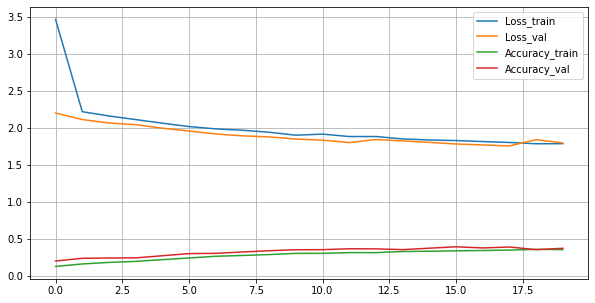

In [103]:
get_train_history(train)


A partir do plot da accuracy é possível vizualisar que o modelo ainda se encontrava ligeiramente em subida, podendo ser benéfica a utilização de mais EPOCHS, é de notar que a loss também se encontra em declinio, o modelo ainda não está num ponto muito estavél. Também é possivel determinar que o modelo não está em overfitting, visto que a accuracy entre treino e validation encontra-se muito próxima.

Confusion matrix, without normalization
Total numb errors test: 6276
Percentage of errors test: 62.760000000000005
              precision    recall  f1-score   support

           0       0.40      0.54      0.46      1000
           1       0.44      0.59      0.50      1000
           2       0.24      0.24      0.24      1000
           3       0.24      0.38      0.29      1000
           4       0.39      0.15      0.22      1000
           5       0.47      0.25      0.32      1000
           6       0.35      0.57      0.43      1000
           7       0.85      0.09      0.16      1000
           8       0.42      0.62      0.50      1000
           9       0.53      0.29      0.38      1000

    accuracy                           0.37     10000
   macro avg       0.43      0.37      0.35     10000
weighted avg       0.43      0.37      0.35     10000

Confusion matrix, without normalization
Total numb errors train: 31394
Percentage of errors train: 62.788
              precis

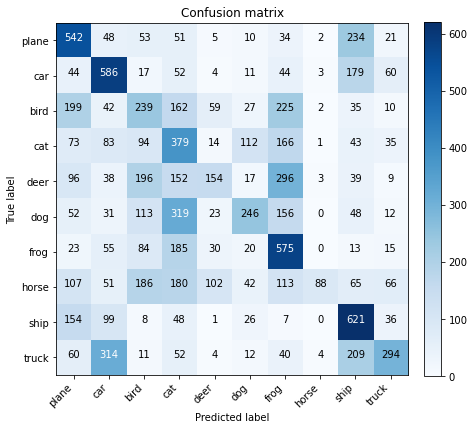

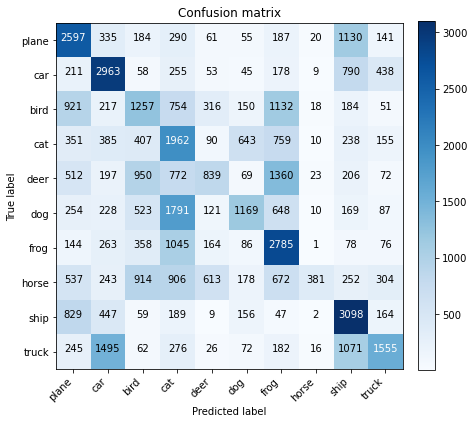

In [104]:
evaluate(mlp2, Xtrain, Xtest,ytest,ytrain)

A accuracy diminuiu comparado com o anterior, como a rede ainda não estava em sinais de overfitting o dropout não foi benéfico para esta caso.

<hr style="border:1px solid black"> </hr>

## Adição de Análise de componentes principais

Realizou-se transformação dos dados em componentes principais para reduzir a dimensionalidade dos dados, e
verificar se esta transformção é benéfica para os resultados do treino da rede MLP.

* Utilizou-se whiten.
* Utilizou-se um valor que permite manter 255 componentes.

In [105]:
from sklearn.decomposition import PCA

pca=PCA(n_components=255,whiten=True).fit(Xtrain)


In [106]:
Xtrain_pca= pca.transform(Xtrain)
Xtest_pca =pca.transform(Xtest)
print('Nº of Principal Components kept: %d'%Xtrain_pca.shape[1])

Nº of Principal Components kept: 255


In [107]:
#Criar Modelo Sequencial
mlp_pca=keras.Sequential()

mlp_pca.add(keras.layers.Dense(1000, input_shape=(255,), activation="relu"))
mlp_pca.add(keras.layers.Dropout(.3))
mlp_pca.add(keras.layers.Dense(1000, activation="relu"))

mlp_pca.add(keras.layers.Dropout(.3))
mlp_pca.add(keras.layers.Dense(505, activation="relu"))
mlp_pca.add(keras.layers.Dropout(.3))
mlp_pca.add(keras.layers.Dense(505, activation="relu"))
mlp_pca.add(keras.layers.Dropout(.3))
mlp_pca.add(keras.layers.Dense(505, activation="relu"))
mlp_pca.add(keras.layers.Dropout(.3))
mlp_pca.add(keras.layers.Dense(505, activation="relu"))


mlp_pca.add(keras.layers.Dense(10, activation="softmax"))
mlp_pca.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 1000)              256000    
                                                                 
 dropout_20 (Dropout)        (None, 1000)              0         
                                                                 
 dense_36 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_21 (Dropout)        (None, 1000)              0         
                                                                 
 dense_37 (Dense)            (None, 505)               505505    
                                                                 
 dropout_22 (Dropout)        (None, 505)               0         
                                                                 
 dense_38 (Dense)            (None, 505)              

In [108]:
mlp_pca.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

train = mlp_pca.fit(Xtrain_pca, ytrain_c, epochs=20, batch_size=1024, validation_data=(Xtest_pca, ytest_c))

Epoch 1/20
49/49 [==============================] - 11s 195ms/step - loss: 2.2757 - accuracy: 0.1343 - val_loss: 2.1965 - val_accuracy: 0.1738
Epoch 2/20
49/49 [==============================] - 7s 151ms/step - loss: 1.9713 - accuracy: 0.2537 - val_loss: 1.7803 - val_accuracy: 0.3573
Epoch 3/20
49/49 [==============================] - 7s 138ms/step - loss: 1.6954 - accuracy: 0.3769 - val_loss: 1.6910 - val_accuracy: 0.3906
Epoch 4/20
49/49 [==============================] - 7s 141ms/step - loss: 1.5424 - accuracy: 0.4346 - val_loss: 1.5181 - val_accuracy: 0.4477
Epoch 5/20
49/49 [==============================] - 7s 140ms/step - loss: 1.4168 - accuracy: 0.4841 - val_loss: 1.4426 - val_accuracy: 0.4829
Epoch 6/20
49/49 [==============================] - 7s 139ms/step - loss: 1.3144 - accuracy: 0.5202 - val_loss: 1.3689 - val_accuracy: 0.5086
Epoch 7/20
49/49 [==============================] - 7s 141ms/step - loss: 1.2273 - accuracy: 0.5518 - val_loss: 1.3634 - val_accuracy: 0.5158
Epoch

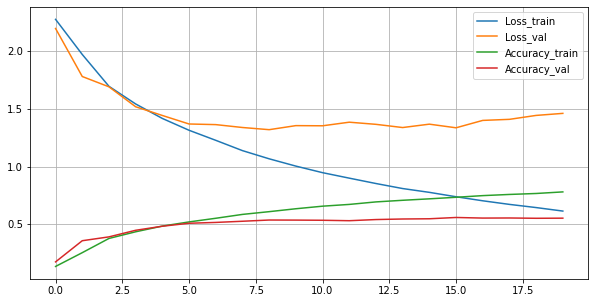

In [109]:
get_train_history(train)


A partir do gráfico é possível notar que existe uma grande discrepância entre a accuracy do treino e validation o que mostra que o modelo está a entrar em sobre-aprendizagem.

Para resolver este problema deveriam ser utilizados valores maiores para o dropout rate.

Confusion matrix, without normalization
Total numb errors test: 4473
Percentage of errors test: 44.73
              precision    recall  f1-score   support

           0       0.69      0.54      0.61      1000
           1       0.75      0.59      0.66      1000
           2       0.40      0.51      0.45      1000
           3       0.36      0.46      0.40      1000
           4       0.39      0.57      0.46      1000
           5       0.55      0.37      0.44      1000
           6       0.61      0.62      0.62      1000
           7       0.77      0.54      0.64      1000
           8       0.63      0.73      0.68      1000
           9       0.66      0.60      0.63      1000

    accuracy                           0.55     10000
   macro avg       0.58      0.55      0.56     10000
weighted avg       0.58      0.55      0.56     10000

Confusion matrix, without normalization
Total numb errors train: 4162
Percentage of errors train: 8.324
              precision    recall  

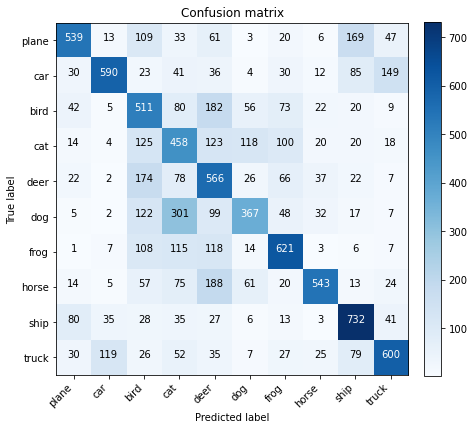

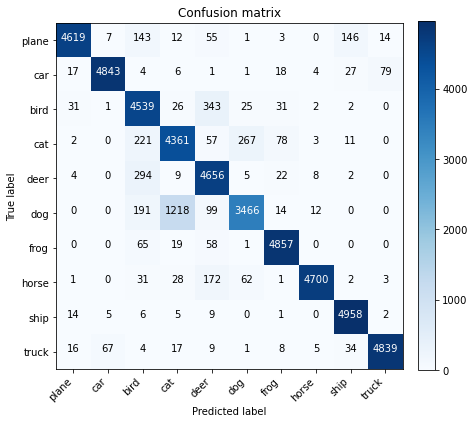

In [110]:
evaluate(mlp_pca, Xtrain_pca, Xtest_pca,ytest,ytrain)


No conjunto de teste foi obtido um valor de 0.55 na accuracy, entretanto no conjunto de treino foi obtido um valor de 0.92. Esta diferença mostra que o modelo entrou em sobre-aprendizagem.

Entretanto esta melhoria da accuracy mostra que a utilização de PCA é adequada neste problema, tendo também a vantagem de reduzir a dimensionalidade dos dados diminuindo otempo de processamento no processo de treino.

<hr style="border:2px solid black"> </hr>

## Testar Normalização da média para um e variância unitária

A técnica de normalização dos dados irá ser agora aplicada aos dados, realizando um rescale da média dos dados para 0 e do desvio padrão para 1.

Média e desvio padrão dos dados no eixo X antes de ser aplicado o StandardScaler.

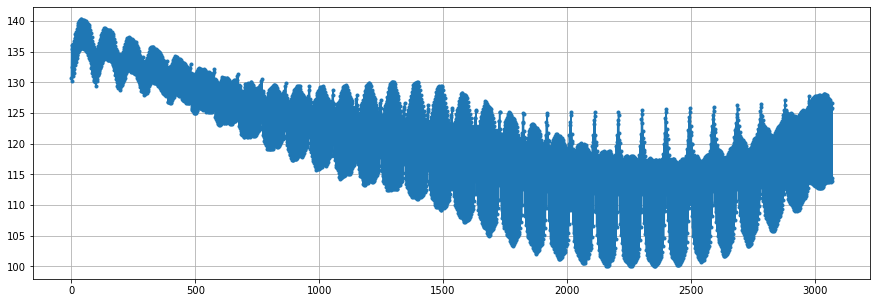

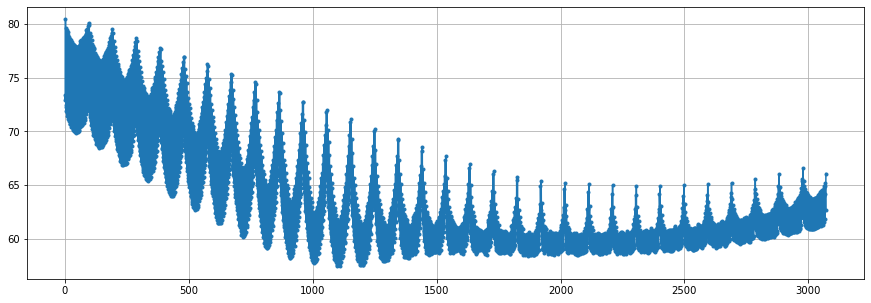

In [63]:
#média dos dados no eixo X
m=np.mean(Xtrain, axis=0)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(m,'.-')

#desvio padrão dos dados no eixo X
s=np.std(Xtrain,axis=0)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(s,'.-')

A partir dos seguintes gráficos pode-se observar a média e o desvio padrão dos dados por cada componente
antes de ser aplicado o StandardScaler, com os dados ainda não normalizados.

### Aplicar Standard Scaler (normalização dos dados)

In [111]:
#Standard Scaler
sc = StandardScaler().fit(Xtrain)
XtrainScale = sc.transform(Xtrain)
XtestScale = sc.transform(Xtest)

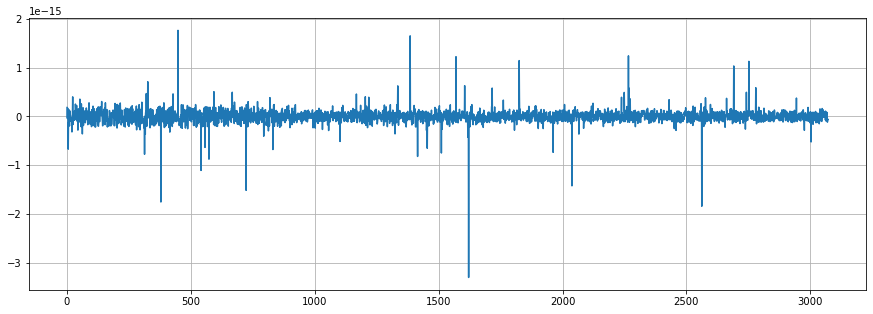

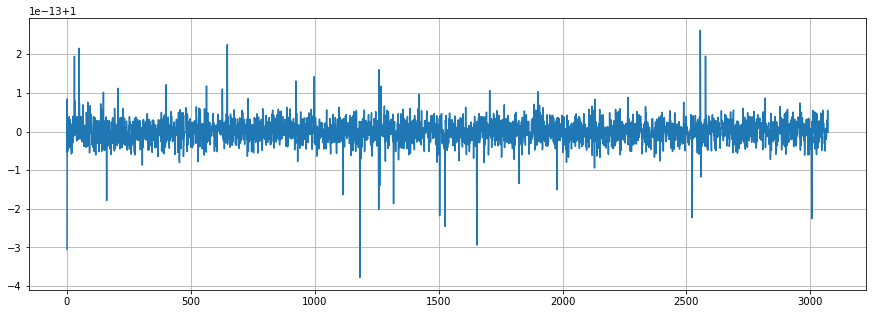

In [112]:
#desvio padrão dos dados no eixo X
s=np.std(XtrainScale,axis=0)
plt.figure(figsize=(15,5))
#média dos dados no eixo X
m=np.mean(XtrainScale,axis=0)
plt.grid()
plt.plot(m)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(s)

Os dados agora apresentam uma média de 0  e uma variância unitária.

In [113]:
#Criar Modelo Sequencial
mlp_s=keras.Sequential()

mlp_s.add(keras.layers.Dense(1000, input_shape=(3072,), activation="relu"))
#mlp.add(keras.layers.Normalization(mean=128,variance=128))
mlp.add(keras.layers.Dropout(.3))
mlp.add(keras.layers.Dense(1000, activation="relu"))

mlp_s.add(keras.layers.Dropout(.3))
mlp_s.add(keras.layers.Dense(505, activation="relu"))
mlp_s.add(keras.layers.Dropout(.3))
mlp_s.add(keras.layers.Dense(505, activation="relu"))
mlp_s.add(keras.layers.Dropout(.3))
mlp_s.add(keras.layers.Dense(505, activation="relu"))
mlp_s.add(keras.layers.Dropout(.3))
mlp_s.add(keras.layers.Dense(505, activation="relu"))

mlp_s.add(keras.layers.Dense(10, activation="softmax"))
mlp_s.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 1000)              3073000   
                                                                 
 dropout_26 (Dropout)        (None, 1000)              0         
                                                                 
 dense_44 (Dense)            (None, 505)               505505    
                                                                 
 dropout_27 (Dropout)        (None, 505)               0         
                                                                 
 dense_45 (Dense)            (None, 505)               255530    
                                                                 
 dropout_28 (Dropout)        (None, 505)               0         
                                                                 
 dense_46 (Dense)            (None, 505)              

In [114]:
mlp_s.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

train = mlp_s.fit(XtrainScale, ytrain_c, epochs=20, batch_size=1024, validation_data=(XtestScale, ytest_c))

Epoch 1/20
49/49 [==============================] - 11s 201ms/step - loss: 1.9819 - accuracy: 0.2846 - val_loss: 1.6826 - val_accuracy: 0.4051
Epoch 2/20
49/49 [==============================] - 9s 190ms/step - loss: 1.7444 - accuracy: 0.3767 - val_loss: 1.6105 - val_accuracy: 0.4396
Epoch 3/20
49/49 [==============================] - 9s 181ms/step - loss: 1.6452 - accuracy: 0.4163 - val_loss: 1.5511 - val_accuracy: 0.4504
Epoch 4/20
49/49 [==============================] - 9s 179ms/step - loss: 1.5910 - accuracy: 0.4357 - val_loss: 1.5209 - val_accuracy: 0.4742
Epoch 5/20
49/49 [==============================] - 9s 181ms/step - loss: 1.5326 - accuracy: 0.4592 - val_loss: 1.4730 - val_accuracy: 0.4888
Epoch 6/20
49/49 [==============================] - 9s 178ms/step - loss: 1.4780 - accuracy: 0.4753 - val_loss: 1.4406 - val_accuracy: 0.5012
Epoch 7/20
49/49 [==============================] - 9s 183ms/step - loss: 1.4482 - accuracy: 0.4872 - val_loss: 1.4246 - val_accuracy: 0.4970
Epoch

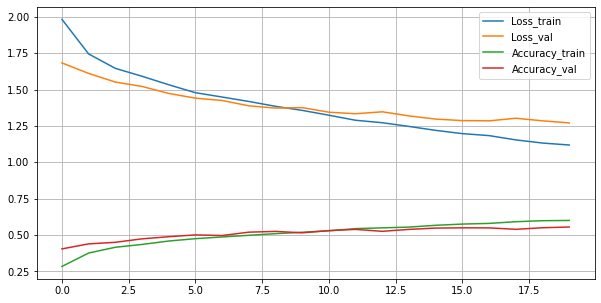

In [115]:
get_train_history(train)


A partir do gráfico é possivél notar que o modelo está a começar a estabilizar, porém a accuracy ainda está ligeiramente em subida portanto o número de EPOCHS podia ter sido superior.

É de notar que o gráfico desmonstra alguns sinais do modelo poder estar a começar a entrar ligeiramente em sobre-aprendizagem, com a accuracy do treino a subir mesmo depois do conjunto de validação ter chegado a um ponto estavél e devido à diferença entre a Loss nos dois conjuntos.

Confusion matrix, without normalization
Total numb errors test: 4426
Percentage of errors test: 44.26
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1000
           1       0.69      0.66      0.68      1000
           2       0.44      0.44      0.44      1000
           3       0.41      0.31      0.35      1000
           4       0.41      0.54      0.47      1000
           5       0.49      0.38      0.43      1000
           6       0.55      0.63      0.59      1000
           7       0.63      0.64      0.64      1000
           8       0.65      0.73      0.69      1000
           9       0.63      0.61      0.62      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000

Confusion matrix, without normalization
Total numb errors train: 14955
Percentage of errors train: 29.909999999999997
              precisi

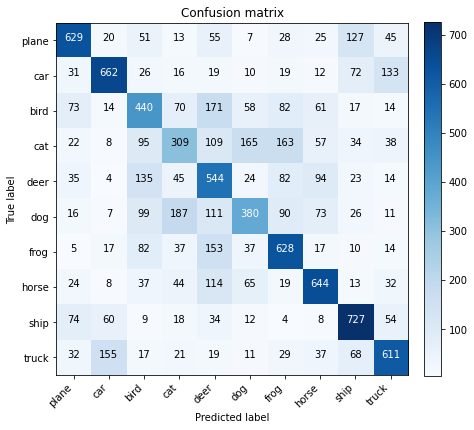

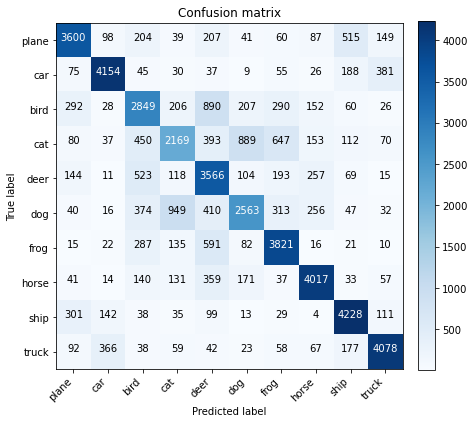

In [116]:
evaluate(mlp, XtrainScale, XtestScale,ytest,ytrain)

Com a utilização de Standard Scaler foi obtido no conjunto de teste uma accuracy de 0.56. Sendo ligeiramente superior ao valor obtido para o conjunto de teste com PCA. Vai ser agora testada a utilização de Standard Scaler e PCA em conjunto.

<hr style="border:1px solid black"> </hr>

### Aplicar PCA com Standard Scaler (normalização dos dados) 

In [118]:
from sklearn.decomposition import PCA

pca=PCA(n_components=255,whiten=True).fit(Xtrain)

In [119]:
Xtrain_pca_stand= pca.transform(Xtrain)
Xtest_pca_stand =pca.transform(Xtest)
print('Nº of Principal Components kept: %d'%Xtrain_pca.shape[1])

Nº of Principal Components kept: 255


In [166]:

#Criar Modelo Sequencial
mlp_pca_stand=keras.Sequential()

mlp_pca_stand.add(keras.layers.Dense(1000, input_shape=(255,), activation="relu"))
#mlp.add(keras.layers.Normalization(mean=128,variance=128))
mlp_pca_stand.add(keras.layers.Dropout(.6))
mlp_pca_stand.add(keras.layers.Dense(1000, activation="relu"))

mlp_pca_stand.add(keras.layers.Dropout(.6))
mlp_pca_stand.add(keras.layers.Dense(505, activation="relu"))




mlp_pca_stand.add(keras.layers.Dense(10, activation="softmax"))
mlp_pca_stand.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 1000)              256000    
                                                                 
 dropout_81 (Dropout)        (None, 1000)              0         
                                                                 
 dense_118 (Dense)           (None, 1000)              1001000   
                                                                 
 dropout_82 (Dropout)        (None, 1000)              0         
                                                                 
 dense_119 (Dense)           (None, 505)               505505    
                                                                 
 dense_120 (Dense)           (None, 10)                5060      
                                                                 
Total params: 1,767,565
Trainable params: 1,767,565
N

In [167]:
mlp_pca_stand.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

train = mlp_pca_stand.fit(Xtrain_pca_stand, ytrain_c, epochs=20, batch_size=1024, validation_data=(Xtest_pca_stand, ytest_c))

Epoch 1/20
49/49 [==============================] - 6s 104ms/step - loss: 2.2368 - accuracy: 0.1785 - val_loss: 1.8746 - val_accuracy: 0.3606
Epoch 2/20
49/49 [==============================] - 5s 103ms/step - loss: 1.8678 - accuracy: 0.3262 - val_loss: 1.6880 - val_accuracy: 0.4164
Epoch 3/20
49/49 [==============================] - 5s 107ms/step - loss: 1.7266 - accuracy: 0.3803 - val_loss: 1.6287 - val_accuracy: 0.4436
Epoch 4/20
49/49 [==============================] - 5s 97ms/step - loss: 1.6385 - accuracy: 0.4135 - val_loss: 1.5675 - val_accuracy: 0.4636
Epoch 5/20
49/49 [==============================] - 5s 99ms/step - loss: 1.5719 - accuracy: 0.4352 - val_loss: 1.5268 - val_accuracy: 0.4789
Epoch 6/20
49/49 [==============================] - 5s 99ms/step - loss: 1.5045 - accuracy: 0.4587 - val_loss: 1.4877 - val_accuracy: 0.4893
Epoch 7/20
49/49 [==============================] - 5s 105ms/step - loss: 1.4562 - accuracy: 0.4779 - val_loss: 1.4417 - val_accuracy: 0.5064
Epoch 8/2

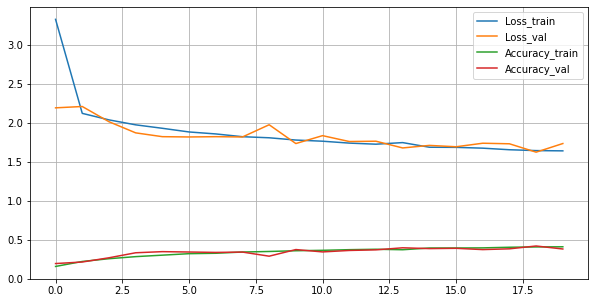

In [194]:
get_train_history(train)


Neste gráfico os valores da accuracy do conjunto de treino e de teste já se encontram mais próximos. 

Os valores da loss estão a descer o que é sinal que se poderia ter utilizado mais EPOCHS, porém só se está a usar 20 epochs de forma a ser justo comparar esta rede com a rede simples da alinea anterior.

Confusion matrix, without normalization
Total numb errors test: 4363
Percentage of errors test: 43.63
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      1000
           1       0.68      0.68      0.68      1000
           2       0.43      0.47      0.45      1000
           3       0.41      0.33      0.36      1000
           4       0.41      0.62      0.49      1000
           5       0.50      0.43      0.46      1000
           6       0.57      0.69      0.63      1000
           7       0.73      0.56      0.63      1000
           8       0.69      0.70      0.70      1000
           9       0.68      0.54      0.60      1000

    accuracy                           0.56     10000
   macro avg       0.58      0.56      0.56     10000
weighted avg       0.58      0.56      0.56     10000

Confusion matrix, without normalization
Total numb errors train: 12375
Percentage of errors train: 24.75
              precision    recall 

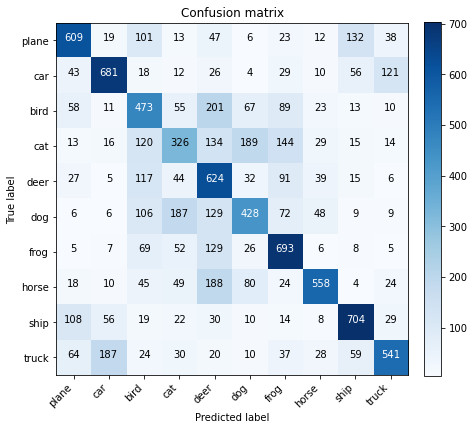

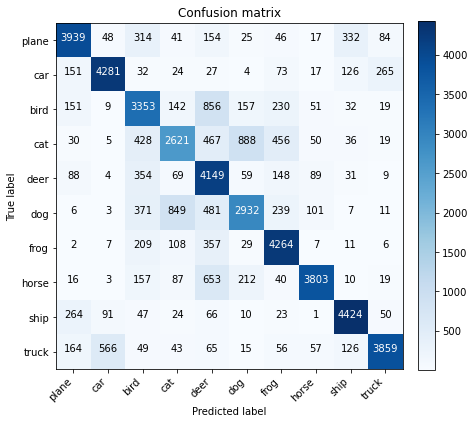

In [169]:
evaluate(mlp_pca_stand, Xtrain_pca_stand, Xtest_pca_stand,ytest,ytrain)

## Rede neuronal final com melhor desempenho

A seguinte rede foi a que obtive melhor desempenho. 

Na rede foi aplicado:

* Callback early stopping
* layers de dropout
* Standard Scaler
* PCA
* callback early stopping para parar o treino se não houver nenhuma melhoria na loss por 5 EPOCHS consecutivas



#### Esta rede obteu uma accuracy de 0.56 no conjunto de teste.

In [173]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


In [174]:
#Criar Modelo Sequencial
mlp_final=keras.Sequential()

mlp_final.add(keras.layers.Dense(1000, input_shape=(255,), activation="relu"))
mlp_final.add(keras.layers.Dropout(.57))
mlp_final.add(keras.layers.Dense(750, activation="relu"))

mlp_final.add(keras.layers.Dropout(.57))
mlp_final.add(keras.layers.Dense(505, activation="relu"))

mlp_final.add(keras.layers.Dense(10, activation="softmax"))
mlp_final.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 1000)              256000    
                                                                 
 dropout_85 (Dropout)        (None, 1000)              0         
                                                                 
 dense_126 (Dense)           (None, 750)               750750    
                                                                 
 dropout_86 (Dropout)        (None, 750)               0         
                                                                 
 dense_127 (Dense)           (None, 505)               379255    
                                                                 
 dense_128 (Dense)           (None, 10)                5060      
                                                                 
Total params: 1,391,065
Trainable params: 1,391,065
N

In [175]:
mlp_final.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

train = mlp_final.fit(Xtrain_pca_stand, ytrain_c, epochs=20, batch_size=1024, callbacks=[callback], validation_data=(Xtest_pca_stand, ytest_c))

Epoch 1/20
49/49 [==============================] - 5s 86ms/step - loss: 2.2146 - accuracy: 0.1851 - val_loss: 1.8822 - val_accuracy: 0.3557
Epoch 2/20
49/49 [==============================] - 4s 88ms/step - loss: 1.8502 - accuracy: 0.3300 - val_loss: 1.6824 - val_accuracy: 0.4208
Epoch 3/20
49/49 [==============================] - 4s 85ms/step - loss: 1.7066 - accuracy: 0.3891 - val_loss: 1.6090 - val_accuracy: 0.4455
Epoch 4/20
49/49 [==============================] - 4s 84ms/step - loss: 1.6178 - accuracy: 0.4227 - val_loss: 1.5536 - val_accuracy: 0.4620
Epoch 5/20
49/49 [==============================] - 4s 83ms/step - loss: 1.5453 - accuracy: 0.4443 - val_loss: 1.4976 - val_accuracy: 0.4816
Epoch 6/20
49/49 [==============================] - 4s 87ms/step - loss: 1.4866 - accuracy: 0.4663 - val_loss: 1.4854 - val_accuracy: 0.4860
Epoch 7/20
49/49 [==============================] - 4s 82ms/step - loss: 1.4327 - accuracy: 0.4855 - val_loss: 1.4235 - val_accuracy: 0.5003
Epoch 8/20
49

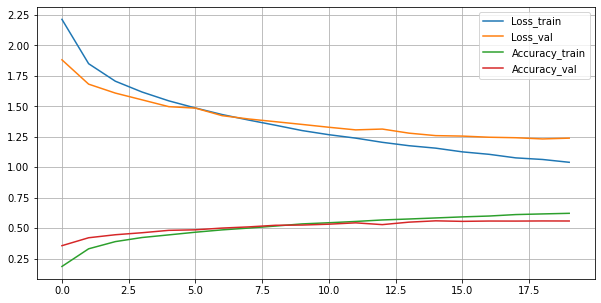

In [176]:
get_train_history(train)


Confusion matrix, without normalization
Total numb errors test: 4416
Percentage of errors test: 44.16
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1000
           1       0.69      0.64      0.67      1000
           2       0.46      0.47      0.46      1000
           3       0.42      0.34      0.38      1000
           4       0.38      0.65      0.48      1000
           5       0.53      0.38      0.45      1000
           6       0.56      0.68      0.62      1000
           7       0.74      0.55      0.63      1000
           8       0.61      0.77      0.68      1000
           9       0.71      0.50      0.59      1000

    accuracy                           0.56     10000
   macro avg       0.58      0.56      0.56     10000
weighted avg       0.58      0.56      0.56     10000

Confusion matrix, without normalization
Total numb errors train: 11994
Percentage of errors train: 23.988
              precision    recall

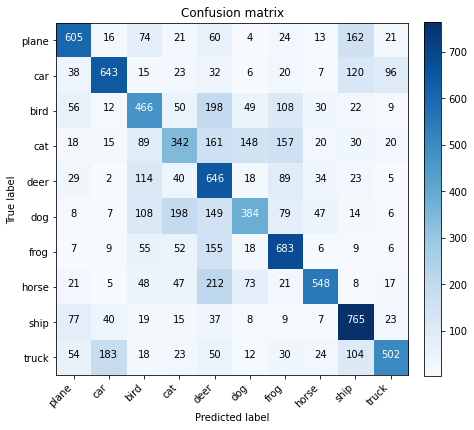

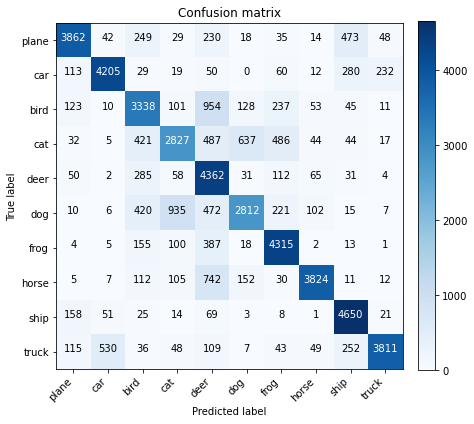

In [178]:
evaluate(mlp_final, Xtrain_pca_stand, Xtest_pca_stand,ytest,ytrain)

Esta rede obteu:
* Uma accuracy de 0.56 no conjunto de teste.
* Uma accuracy de 0.76 no conjunto de treino.

O maior número erros ocorre em classificar de forma errada cães como gatos e passáros como viados, possivelmente devido à semelhança entre as suas cores

<hr style="border:2px solid black"> </hr>


## Observações

Os resultados obtidos para as 2 redes neuronais foram os seguintes:
 
A rede MLP simples teve:

* Accuracy no conjunto de teste: 0.38
* Accuracy no conjunto de treino: 0.38

A rede MLP ótima teve:

* Accuracy no conjunto de teste: 0.56
* Accuracy no conjunto de treino: 0.76


A partir dos resultados obtidos é possível notar uma grande melhoria nos resultados obtidos, tendo apenas a desvantagem da segunda rede neuronal ter um maior tempo de processamento no processo de treino.

* A normalização dos dados foi muito importante para um bom desempenho da rede neuronal.

* A utilização de PCA permitiu reduzir drásticamente a dimensionalidade dos dados, tornando o processo de treino mais rápido e aumentando a accuracy da rede.

* A utilização de camadas Dropout foi muito útil para combater sobre-aprendizagem.

* A rede neuronal funcionou melhor com poucas camadas mas com valores "elevados" de unidades por camada.

<hr style="border:2px solid black"> </hr>
